## Loading data

In [8]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Загрузка данных
fraud_data = pd.read_parquet('transaction_fraud_data.parquet')
fraud_data['timestamp'] = pd.to_datetime(fraud_data['timestamp'])
currency_data = pd.read_parquet('historical_currency_exchange.parquet')

# Основные статистики
print("=== Общая статистика ===")
print(f"Всего транзакций: {len(fraud_data):,}")
print(f"Количество уникальных клиентов: {fraud_data['customer_id'].nunique():,}")
print(f"Количество уникальных карт: {fraud_data['card_number'].nunique():,}")

# Статистика по мошенничеству
fraud_stats = fraud_data['is_fraud'].value_counts(normalize=True) * 100
print("\n=== Статистика мошенничества ===")
print(f"Доля мошеннических транзакций: {fraud_stats[True]:.2f}%")
print(f"Доля легитимных транзакций: {fraud_stats[False]:.2f}%")

# Статистика по категориям вендоров
print("\n=== Распределение по категориям вендоров ===")
vendor_stats = fraud_data['vendor_category'].value_counts(normalize=True) * 100
print(vendor_stats.head(10))

# Статистика по сумме транзакций
print("\n=== Статистика сумм транзакций ===")
print(f"Средняя сумма: {fraud_data['amount'].mean():.2f}")
print(f"Медианная сумма: {fraud_data['amount'].median():.2f}")
print(f"Максимальная сумма: {fraud_data['amount'].max():.2f}")
print(f"Минимальная сумма: {fraud_data['amount'].min():.2f}")

# Дополнительная статистика по мошенническим транзакциям
fraud_transactions = fraud_data[fraud_data['is_fraud']]
print("\n=== Дополнительная статистика по мошенническим транзакциям ===")
print(f"Средняя сумма мошеннической транзакции: {fraud_transactions['amount'].mean():.2f}")
print(f"Наиболее частый тип карты: {fraud_transactions['card_type'].mode()[0]}")
print(f"Наиболее частый канал: {fraud_transactions['channel'].mode()[0]}")

=== Общая статистика ===
Всего транзакций: 7,483,766
Количество уникальных клиентов: 4,869
Количество уникальных карт: 5,000

=== Статистика мошенничества ===
Доля мошеннических транзакций: 19.97%
Доля легитимных транзакций: 80.03%

=== Распределение по категориям вендоров ===
vendor_category
Healthcare       12.517361
Restaurant       12.509450
Entertainment    12.509384
Retail           12.505509
Travel           12.504266
Gas              12.499068
Grocery          12.480735
Education        12.474228
Name: proportion, dtype: float64

=== Статистика сумм транзакций ===
Средняя сумма: 47924.68
Медианная сумма: 1177.45
Максимальная сумма: 6253152.62
Минимальная сумма: 0.01

=== Дополнительная статистика по мошенническим транзакциям ===
Средняя сумма мошеннической транзакции: 118773.59
Наиболее частый тип карты: Basic Debit
Наиболее частый канал: pos


### Смотрим распределения суммы транзакций

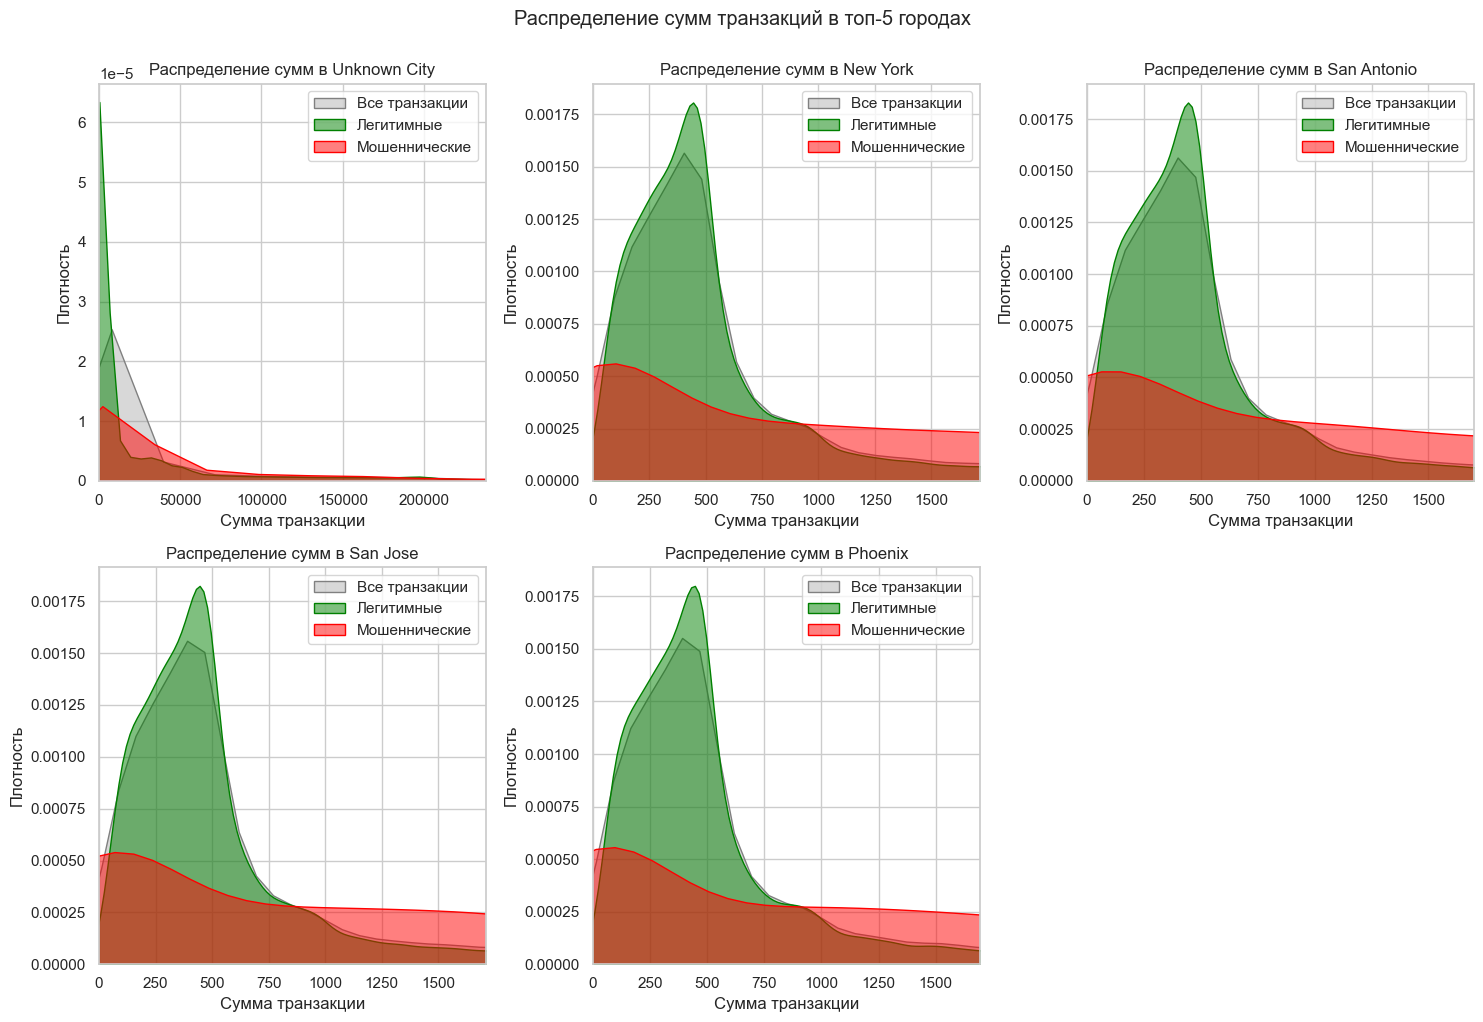

In [5]:
top_cities = fraud_data.groupby('city')['amount'].mean().sort_values(ascending=False).head(5).index

# Фильтрация данных только для топ-5 городов
top_cities_data = fraud_data[fraud_data['city'].isin(top_cities)]

# Настройка стиля графиков
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Построение распределений для каждого города
for i, city in enumerate(top_cities, 1):
    plt.subplot(2, 3, i)
    
    # Общее распределение
    sns.kdeplot(data=top_cities_data[top_cities_data['city'] == city], 
                x='amount', 
                color='gray', 
                label='Все транзакции',
                fill=True,
                alpha=0.3)
    
    # Не мошеннические транзакции
    sns.kdeplot(data=top_cities_data[(top_cities_data['city'] == city) & 
                                    (top_cities_data['is_fraud'] == False)], 
                x='amount', 
                color='green', 
                label='Легитимные',
                fill=True,
                alpha=0.5)
    
    # Мошеннические транзакции
    sns.kdeplot(data=top_cities_data[(top_cities_data['city'] == city) & 
                                    (top_cities_data['is_fraud'] == True)], 
                x='amount', 
                color='red', 
                label='Мошеннические',
                fill=True,
                alpha=0.5)
    
    plt.title(f'Распределение сумм в {city}')
    plt.xlabel('Сумма транзакции')
    plt.ylabel('Плотность')
    plt.legend()
    plt.xlim(0, top_cities_data[top_cities_data['city'] == city]['amount'].quantile(0.95))  # Ограничиваем выбросы

plt.tight_layout()
plt.suptitle('Распределение сумм транзакций в топ-5 городах', y=1.02)
plt.show()

Однако не совсем правильно сравнивать транзакции в разной валюте, поэтому переведем это в USD

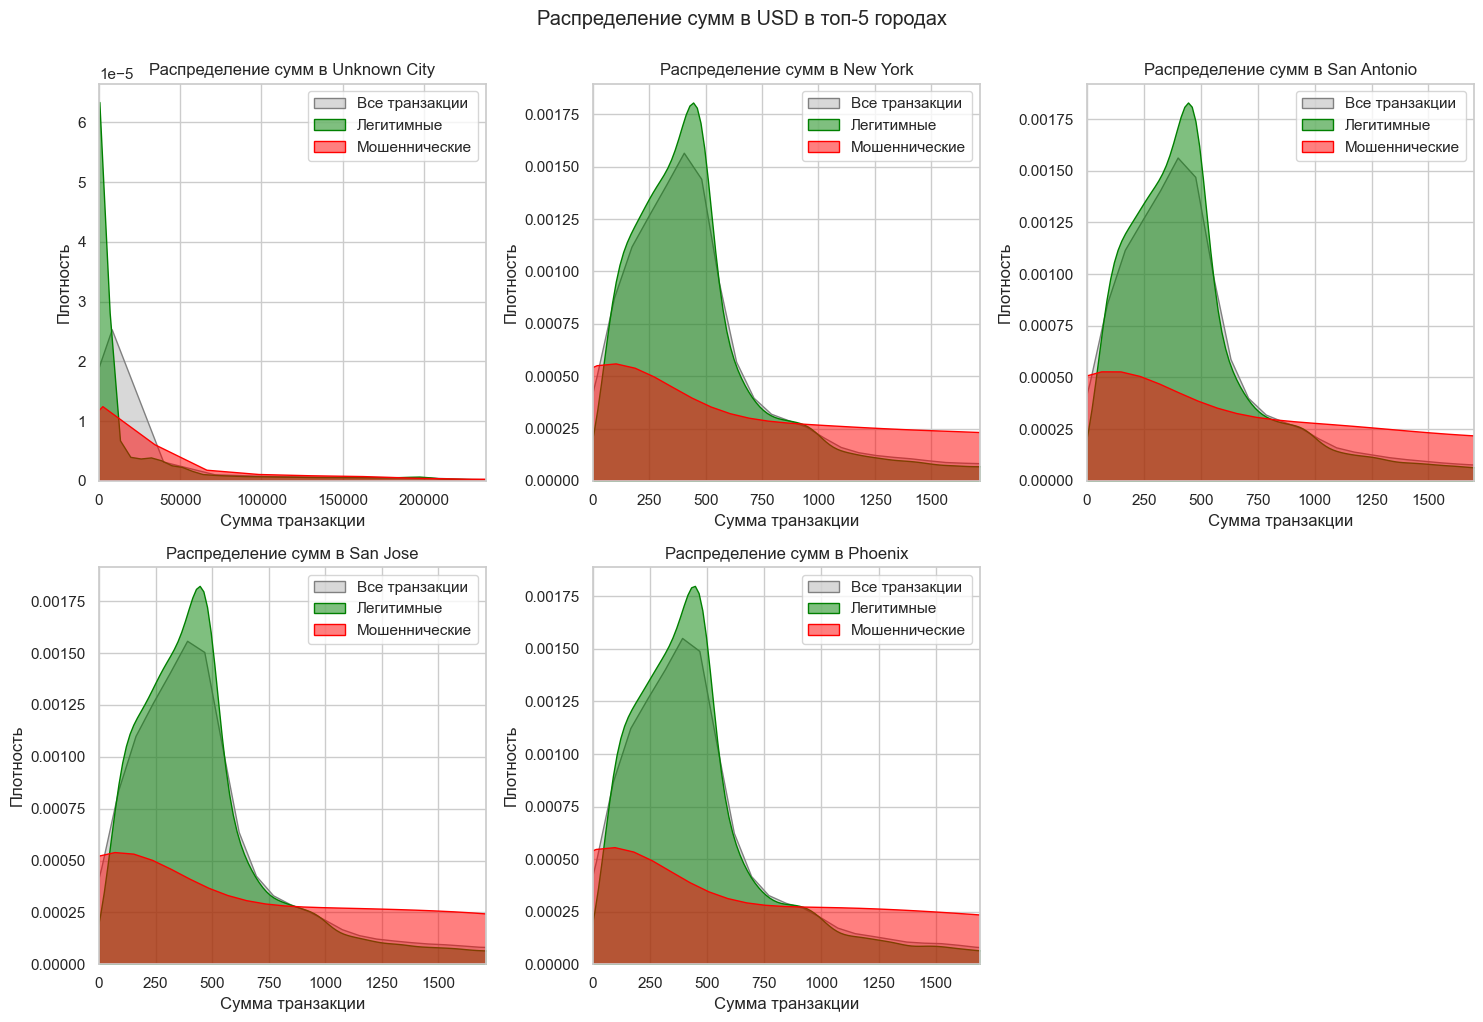

In [7]:
currency_data['date'] = pd.to_datetime(currency_data['date']).dt.date
fraud_data['date'] = pd.to_datetime(fraud_data['timestamp']).dt.date

currency_melted = currency_data.melt(id_vars='date', 
                                   var_name='currency', 
                                   value_name='exchange_rate')

merged_data = pd.merge(fraud_data,
                      currency_melted,
                      left_on=['date', 'currency'],
                      right_on=['date', 'currency'],
                      how='left')
# Заполняем пропущенные курсы (если валюта USD или курс не найден)
merged_data['exchange_rate'] = merged_data['exchange_rate'].fillna(1.0)
# Конвертируем в USD
merged_data['amount'] = merged_data['amount'] / merged_data['exchange_rate']

top_cities = fraud_data.groupby('city')['amount'].mean().sort_values(ascending=False).head(5).index

# Фильтрация данных только для топ-5 городов
top_cities_data = fraud_data[fraud_data['city'].isin(top_cities)]

# Настройка стиля графиков
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Построение распределений для каждого города
for i, city in enumerate(top_cities, 1):
    plt.subplot(2, 3, i)
    
    # Общее распределение
    sns.kdeplot(data=top_cities_data[top_cities_data['city'] == city], 
                x='amount', 
                color='gray', 
                label='Все транзакции',
                fill=True,
                alpha=0.3)
    
    # Не мошеннические транзакции
    sns.kdeplot(data=top_cities_data[(top_cities_data['city'] == city) & 
                                    (top_cities_data['is_fraud'] == False)], 
                x='amount', 
                color='green', 
                label='Легитимные',
                fill=True,
                alpha=0.5)
    
    # Мошеннические транзакции
    sns.kdeplot(data=top_cities_data[(top_cities_data['city'] == city) & 
                                    (top_cities_data['is_fraud'] == True)], 
                x='amount', 
                color='red', 
                label='Мошеннические',
                fill=True,
                alpha=0.5)
    
    plt.title(f'Распределение сумм в {city}')
    plt.xlabel('Сумма транзакции')
    plt.ylabel('Плотность')
    plt.legend()
    plt.xlim(0, top_cities_data[top_cities_data['city'] == city]['amount'].quantile(0.95))  # Ограничиваем выбросы

plt.tight_layout()
plt.suptitle('Распределение сумм в USD в топ-5 городах', y=1.02)
plt.show()

Ладно, ничего почти и не поменялось, собственно мошеннические операции все еще выглядят как равномерное с очень большими хвостами. Думаю первый спуск это небольшие скамы а все далее это на усмотрение 'сколько есть на счету'

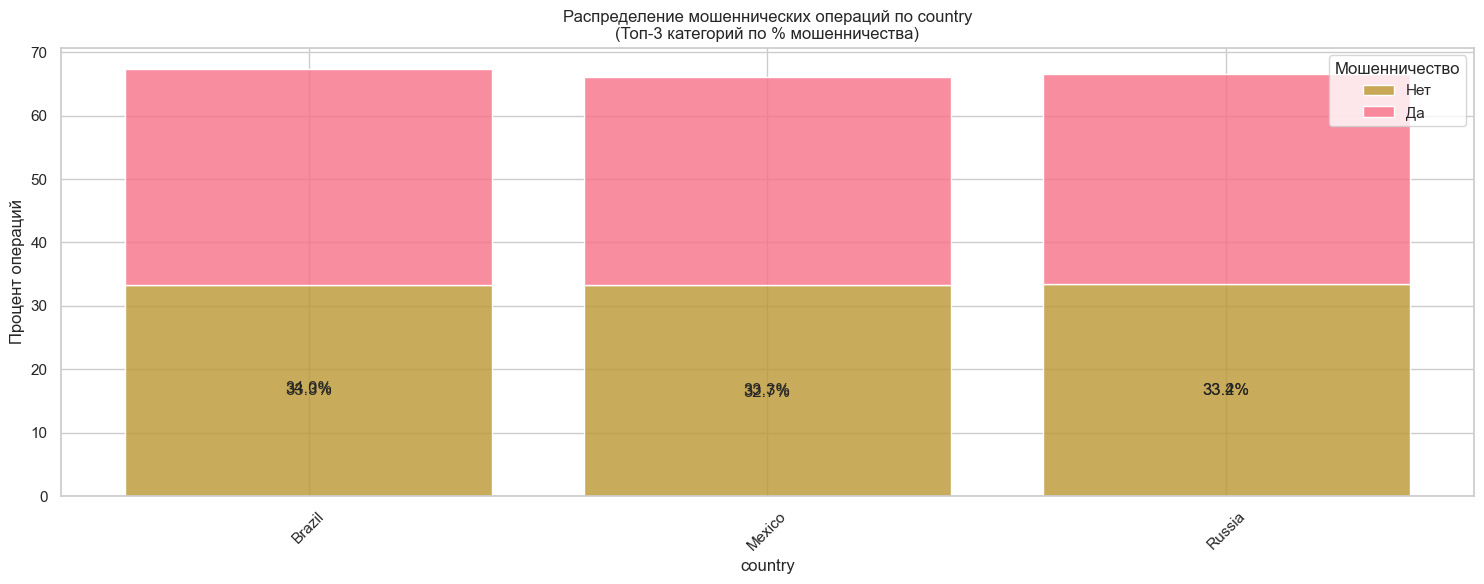

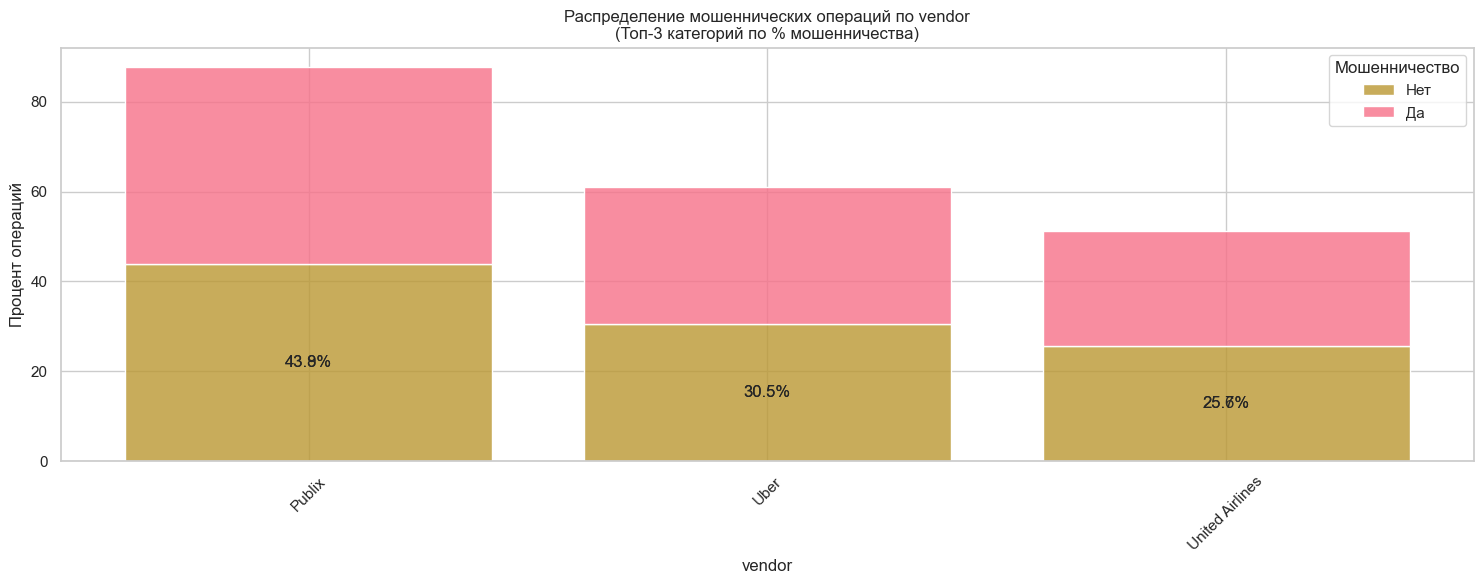

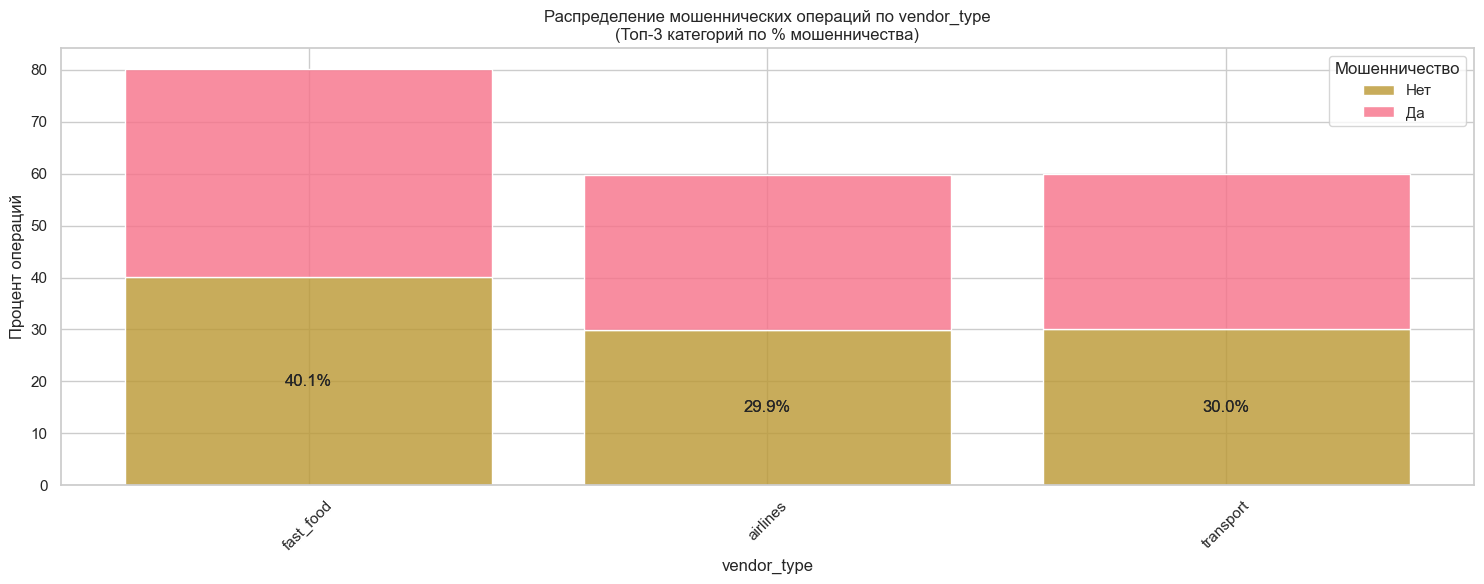

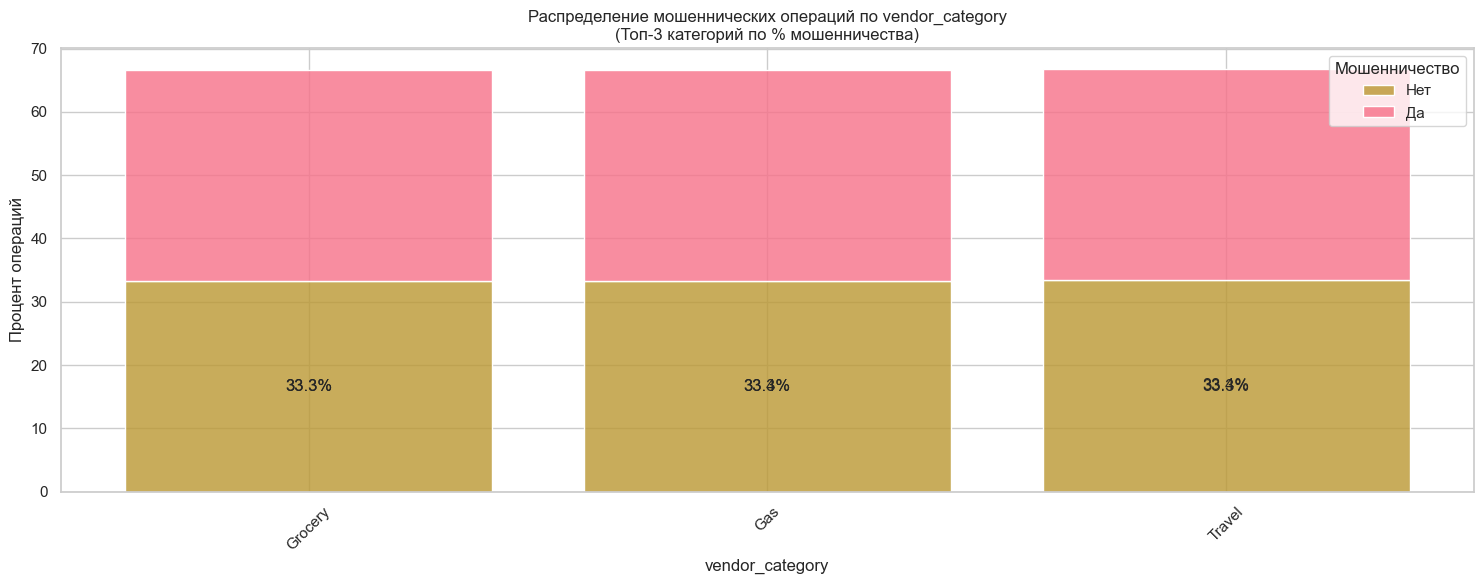

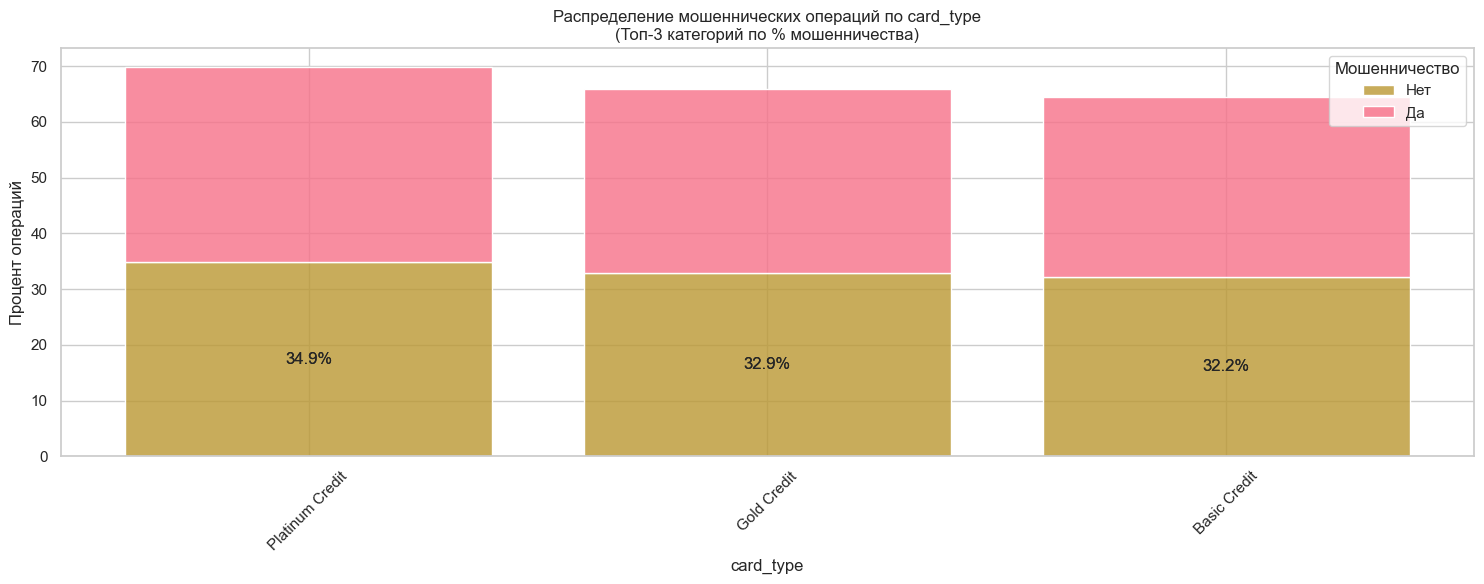

/var/folders/z2/kxjb41213z74h6nbpr1f79sr0000gn/T/ipykernel_92174/2355908286.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='Reds_r')


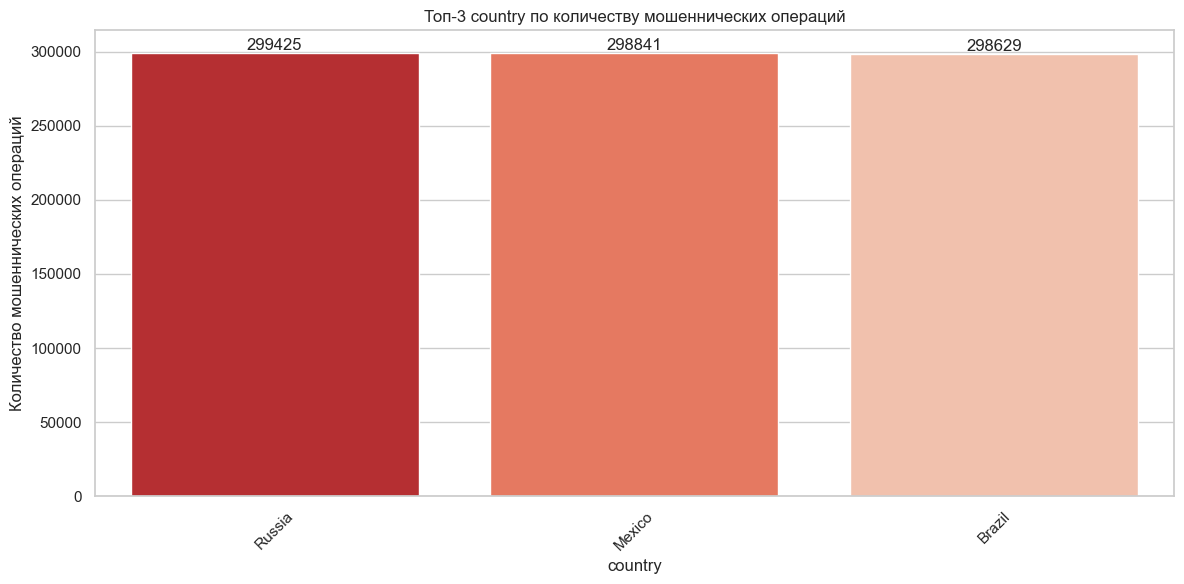

/var/folders/z2/kxjb41213z74h6nbpr1f79sr0000gn/T/ipykernel_92174/2355908286.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='Reds_r')


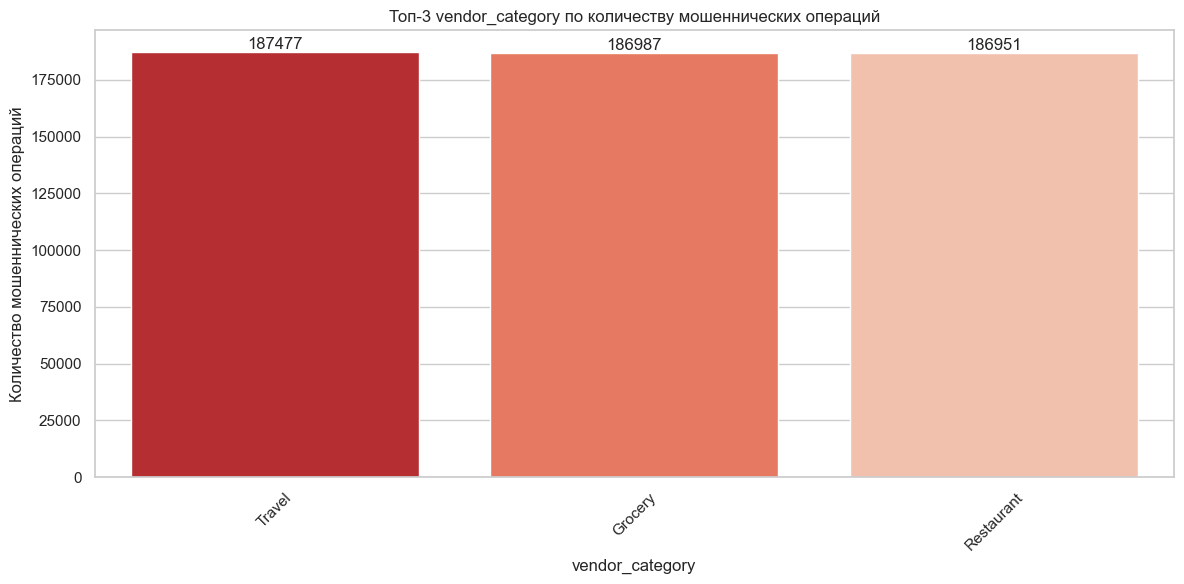

In [9]:
def plot_fraud_distribution(data, column, top_n=3):
    # Вычисляем топ-N категорий с наибольшим % мошенничества
    fraud_rates = (data.groupby(column)['is_fraud']
                  .mean()
                  .sort_values(ascending=False)
                  .head(top_n))
    
    # Фильтруем данные только для топ категорий
    top_data = data[data[column].isin(fraud_rates.index)]
    
    # Настройка графика
    plt.figure(figsize=(15, 6))
    sns.set_palette("husl")
    
    # Гистограмма с накоплением
    ax = sns.histplot(data=top_data, x=column, hue='is_fraud', 
                     multiple='stack', stat='percent', common_norm=False,
                     shrink=0.8, alpha=0.8)
    
    # Добавляем аннотации с % мошенничества
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width()/2., height/2, 
                    f'{height:.1f}%', ha='center', va='center')
    
    plt.title(f'Распределение мошеннических операций по {column}\n(Топ-{top_n} категорий по % мошенничества)')
    plt.xlabel(column)
    plt.ylabel('Процент операций')
    plt.xticks(rotation=45)
    plt.legend(title='Мошенничество', labels=['Нет', 'Да'])
    plt.tight_layout()
    plt.show()

# 1. По странам (топ-3 по % мошенничества)
plot_fraud_distribution(fraud_data, 'country')

# 2. По вендорам (топ-3)
plot_fraud_distribution(fraud_data, 'vendor')

# 3. По типам вендоров
plot_fraud_distribution(fraud_data, 'vendor_type')

# 4. По категориям вендоров
plot_fraud_distribution(fraud_data, 'vendor_category')

# 5. По типам карт
plot_fraud_distribution(fraud_data, 'card_type')

# Дополнительно: абсолютные числа мошеннических операций
def plot_top_fraud_counts(data, column, top_n=3):
    fraud_counts = (data[data['is_fraud']]
                   .groupby(column)
                   .size()
                   .sort_values(ascending=False)
                   .head(top_n))
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='Reds_r')
    plt.title(f'Топ-{top_n} {column} по количеству мошеннических операций')
    plt.xlabel(column)
    plt.ylabel('Количество мошеннических операций')
    plt.xticks(rotation=45)
    for i, v in enumerate(fraud_counts.values):
        plt.text(i, v, str(v), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

plot_top_fraud_counts(fraud_data, 'country')
plot_top_fraud_counts(fraud_data, 'vendor_category')